In this notebook, we want to check if there is any local order parameter for us to define the phase transition in our Kitaev ladder.

In [1]:
# import the model file we designed
"""
    Here we want to clarify that the 'kitaev_ladder_snake1.py' file
    is different from the 'kitaev_ladder_snake.py' in that the *1 file 
    uses the original representation of xyz,
    i.e. Jz stands for the sigmazsigmaz interactions which starts from
    the first pair of neighbors; Jx being the second pair; and Jy being
    the third-nearest-neighbors.
    
    The purpose of designing so many different 1D correspondences is 
    to serve for different phases.
    For example, when the Jx interaction is very weak, the optimal 
    choice is to make Jx as the third-nearest neighbors; when Jy is 
    weak the similar case holds.
"""
from kitaev_ladder_snake1 import run_atomic, save_after_run, finite_scaling, load_data, fDMRG_KL

# the folder name for storing data
folder_prefix = 'snake/'

# generate the function for running and storing the data in the folder we want
run_save = save_after_run(run_atomic, folder_prefix=folder_prefix)

In [2]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy import optimize

import scipy.sparse as sparse

In [3]:
# naming function for the png of finite scaling
def naming(Jx, Jy, Jz, L):
    return f"_Jx_{Jx}_Jy_{Jy}_Jz_{Jz}_L_{L}.png"

The spectra of two candidates can be given by

$$\epsilon(k) = \pm\sqrt{(J_z + (J_x + D J_y)\cos k)^2 + (J_x - D J_y)^2\sin^2k}.$$

## True Energy

In [4]:
import scipy.integrate as integrate

def e_k_sorted(k, Jx, Jy, Jz, D):
    Jp = Jx + D*Jy
    J2 = Jx**2 + Jy**2 + Jz**2 # J square
    return np.sqrt(J2 + 2 * Jz * Jp * np.cos(k) + 2 * D * Jx * Jy * np.cos(2*k))

def E_sorted(Jx, Jy, Jz, D):
    assert D==1 or D==-1
    e_k_D_sorted_func = lambda k:e_k_sorted(k, Jx, Jy, Jz, D)
    return integrate.quad(e_k_D_sorted_func, -np.pi, np.pi)[0] * -1 / (16*np.pi)

def E_true(Jx, Jy, Jz):
    D_true = 1 if Jy*Jx < 0 else -1
    E_true = E_sorted(Jx, Jy, Jz, D_true)
    return E_true

def E_false(Jx, Jy, Jz):
    D_true = -1 if Jy*Jx < 0 else 1
    E_true = E_sorted(Jx, Jy, Jz, D_true)
    return E_true

# Correlation Function

## X Region

We choose a typical gapped point living in the $X$ region, i.e.
$$ J_x - J_y > |{J_z}|$$

In [5]:
# set the region to be the circle `r = x**2 + y**2 = 2, z=.5`

r = 2
theta = np.pi * 9 / 90
Jx = r*np.cos(theta)
Jy = r*np.sin(theta)
Jz = .5

result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=4, chi=128, bc='periodic', bc_MPS='infinite')

Reading 'L'=4 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.902113032590307 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.6180339887498948 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDM

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


## Validation of the Ground State

### Test with our theoretical energy

In [6]:
assert np.abs(result['energy'] - E_true(Jx, Jy, Jz)) < 1e-10

### Test with our local symmetries

In [7]:
psi = result['psi']
k=0
print("Norm: <psi|psi> = %.1f" % psi.norm)
for k in range(20):
    if k % 2 == 0:
        print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sx', k), ('Sy', k+1), ('Sy', k+2), ('Sx', k+3)])))
#     

Norm: <psi|psi> = 1.0
Local Symmetry: W0 = 1.0
Local Symmetry: W1 = 1.0
Local Symmetry: W2 = 1.0
Local Symmetry: W3 = 1.0
Local Symmetry: W4 = 1.0
Local Symmetry: W5 = 1.0
Local Symmetry: W6 = 1.0
Local Symmetry: W7 = 1.0
Local Symmetry: W8 = 1.0
Local Symmetry: W9 = 1.0


## Local Operators

In [8]:
ops = ['Sx', 'Sy', 'Sz']

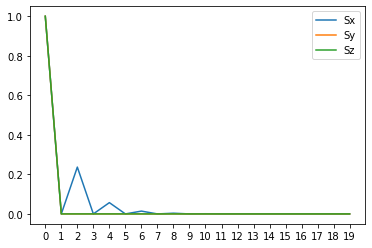

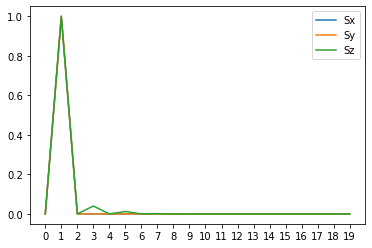

In [9]:
site_left = [0]
site_right = 20
xticks=range(site_right)
for op in ops:
    cf_list = 4*psi.correlation_function(op, op, site_left, site_right, opstr=op)[0, :]
    plt.plot(xticks, np.abs(cf_list), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.show()

site_left = [1]
site_right = 20
xticks=range(site_right)
for op in ops:
    cf_list = 4*psi.correlation_function(op, op, site_left, site_right, opstr=op)[0, :]
    plt.plot(xticks, np.abs(cf_list), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.show()

Q: solvability?

## Double Local Operators

Now let's try the 'double local operators'.

That is, we used two local, neighboring operators combined together as our observed quantity.

In [10]:
def double_local_op(psi, op='Sx', i0=1, d=1):
    return psi.expectation_value_term(term=[(op, i0), (op, i0+1), (op, i0+d*2), (op, i0+d*2+1)])*16
def double_local_op_corr_func(psi, op='Sx', i0=1, dN=9):
    return [double_local_op(psi, op=op, i0=i0, d=d) for d in range(dN)]

[1.0000000000000056, 0.9125260097711534, 0.9275264577254282, 0.8991795018519586, 0.8987500110560571, 0.8979157884722947, 0.8978199467305463, 0.897752973978285, 0.8977370482520552, 0.8977288996478081, 0.8977262039899874, 0.897724963872422, 0.8977244834650054, 0.8977242687493526, 0.8977241787437947, 0.8977241385163728, 0.8977241209169525, 0.897724112977994, 0.8977241094134902, 0.8977241077876146]


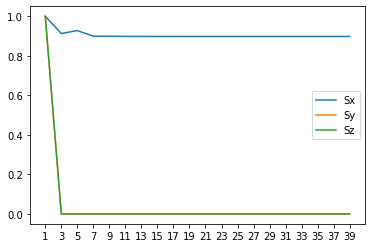

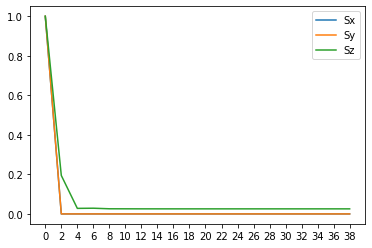

In [11]:
ops = ['Sx', 'Sy', 'Sz']
N=20

xticks=range(1, 2*N, 2)
for op in ops:
    plt.plot(xticks, double_local_op_corr_func(psi, op=op, i0=1, dN=N), label=op)
print(double_local_op_corr_func(psi, op='Sx', i0=1, dN=N))
plt.legend()
plt.xticks(xticks)
plt.show()

xticks=range(0, 2*N, 2)
for op in ops:
    plt.plot(xticks, double_local_op_corr_func(psi, op=op, i0=0, dN=N), label=op)
plt.legend()
plt.xticks(xticks)
plt.show()


In [14]:
Jp = Jx + Jy
Jm = Jx - Jy
ratio = Jp / Jm
Delta = np.sqrt(ratio) * (1 - (Jz / Jm)**2)**(1/4) / (2 * (1 + ratio))
print(Delta)

0.22691338311389625


In [ ]:
def double_local_op(psi, op='Sx', i0=1, d=1):
    return psi.expectation_value_term(term=[(op, i0), (op, i0+1), (op, i0+d*2), (op, i0+d*2+1)])*16
def double_local_op_corr_func(psi, op='Sx', i0=1, dN=9):
    return [double_local_op(psi, op=op, i0=i0, d=d) for d in range(dN)]

## Non-local operators

In [428]:
def nonlocal_op(psi, op='Sx', i0=1, end=11):
    if end==i0:
        return 1.0
    return psi.expectation_value_term(term=[(op, i) for i in range(i0, end)])*(2**(end-i0))
def nonlocal_op_corr_func(psi, op='Sx', i0=1, N=20):
    return [nonlocal_op(psi, op=op, i0=i0, end=i0+2*d) for d in range(N)]

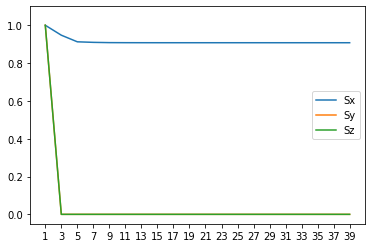

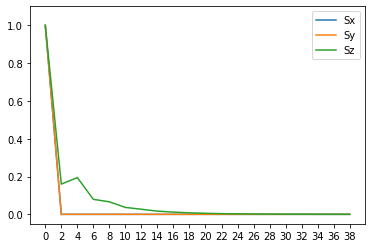

In [429]:
ops = ['Sx', 'Sy', 'Sz']
N=20

xticks=range(1, 2*N, 2)
for op in ops:
    plt.plot(xticks, np.abs(nonlocal_op_corr_func(psi, op=op, i0=1, N=N)), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.ylim(top=1.1)
plt.show()

xticks=range(0, 2*N, 2)
for op in ops:
    plt.plot(xticks, np.abs(nonlocal_op_corr_func(psi, op=op, i0=0, N=N)), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.ylim(top=1.1)
plt.show()


## Double Local Operators

Now let's try other sort of 'double local operators'.

That is, we used two local, neighboring operators combined together as our |

In [20]:
def double_local_op_diff(psi, op1='Sx', op2='Sz', i0=1, d0=1, d=1):
    return psi.expectation_value_term(term=[(op1, i0), (op2, i0+d0), (op1, i0+d*2), (op2, i0+d0+d*2)])*16
def double_local_op_diff_corr_func(psi, op1='Sx', op2='Sz', i0=1, d0=1, dN=9):
    return [double_local_op_diff(psi, op1=op1, op2=op2, i0=i0, d0=d0, d=d) for d in range(dN)]

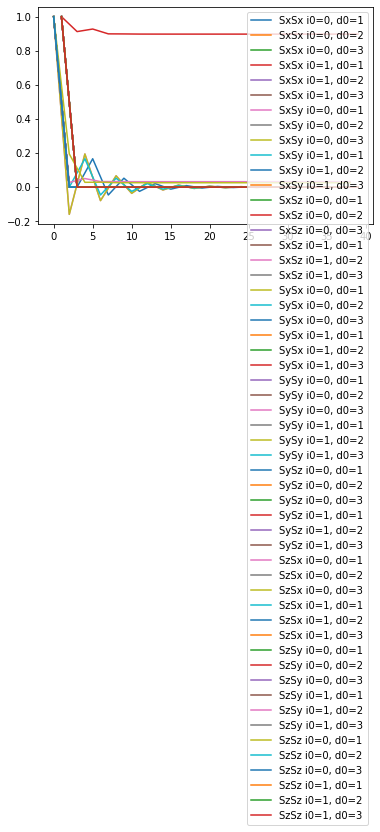

In [27]:
ops1 = [
    'Sx', 
    'Sy', 
    'Sz',
       ]
ops2 = [
    'Sx', 
    'Sy', 
    'Sz',
]
i0_list = [0, 1]
d0_list = [1, 2, 3]


N = 20

for op1 in ops1:
    for op2 in ops2:
        for i0 in i0_list:
            for d0 in d0_list:
                xticks=range(i0, 2*N, 2)
                plt.plot(
                    xticks, 
                    double_local_op_diff_corr_func(
                        psi, 
                        op1=op1, op2=op2, i0=i0, d0=d0, dN=N), 
                    label=op1+op2+f' i0={i0}, d0={d0}')
                
plt.legend()
plt.show()

In [432]:
Jp = Jx + Jy
Jm = Jx - Jy
ratio = Jp / Jm
Delta = np.sqrt(ratio) * (1 - (Jz / Jm)**2)**(1/4) / (2 * (1 + ratio))
print(Delta)

0.22691338311389625


## Triple Local Operators

In [45]:
from itertools import permutations, product
print(list(permutations(ops)))
i0s = [0, 1, 2, 3]
print(list(permutations(i0s, 3)))

[('Sx', 'Sy', 'Sz'), ('Sx', 'Sz', 'Sy'), ('Sy', 'Sx', 'Sz'), ('Sy', 'Sz', 'Sx'), ('Sz', 'Sx', 'Sy'), ('Sz', 'Sy', 'Sx')]
[(0, 1, 2), (0, 1, 3), (0, 2, 1), (0, 2, 3), (0, 3, 1), (0, 3, 2), (1, 0, 2), (1, 0, 3), (1, 2, 0), (1, 2, 3), (1, 3, 0), (1, 3, 2), (2, 0, 1), (2, 0, 3), (2, 1, 0), (2, 1, 3), (2, 3, 0), (2, 3, 1), (3, 0, 1), (3, 0, 2), (3, 1, 0), (3, 1, 2), (3, 2, 0), (3, 2, 1)]


In [42]:
def multiple_local_op_diff(psi, ops=['Sx', 'Sy', 'Sz'], i0s=[0, 1, 2], d=1):
    return psi.expectation_value_term(term=[(op, i0) for op, i0 in zip(ops, i0s)] + [(op, i0+d) for op, i0 in zip(ops, i0s)])*(2**(2*len(ops)))
def multiple_local_op_diff_corr_func(psi, ops=['Sx', 'Sy', 'Sz'], i0s=[0, 1, 2], dN=20):
    return [multiple_local_op_diff(psi, ops=ops, i0s=i0s, d=d) for d in range(dN)]

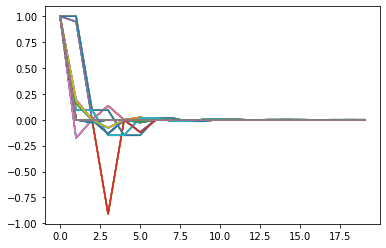

In [46]:
for ops_input in list(product(ops, ops, ops)):
    for i0s_input in list(permutations(i0s, 3)):
        plt.plot(multiple_local_op_diff_corr_func(psi, ops=ops_input, i0s=i0s_input))

## Quartic

('Sx', 'Sy', 'Sy', 'Sx')
('Sx', 'Sz', 'Sz', 'Sx')


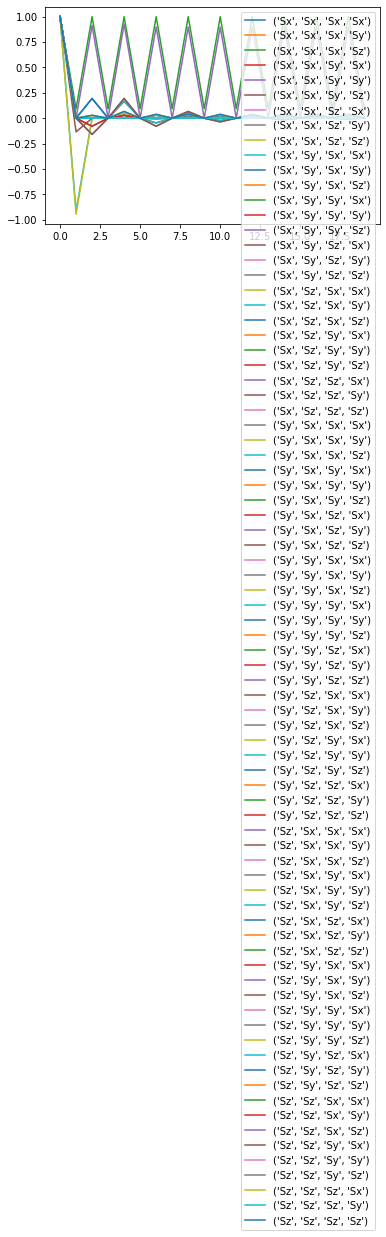

In [49]:
for ops_input in list(product(ops, ops, ops, ops)):
    corr_values = multiple_local_op_diff_corr_func(psi, ops=ops_input, i0s=i0s)
    plt.plot(corr_values,label=f'{ops_input}')
    if np.average(corr_values) > .25:
        print(ops_input)
plt.legend()

('Sx', 'Sy', 'Sy', 'Sx')
('Sx', 'Sz', 'Sz', 'Sx')


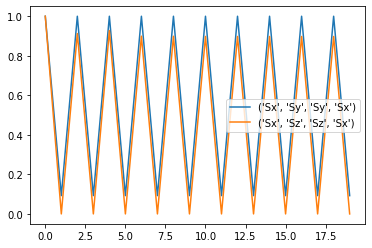

In [50]:
for ops_input in list(product(ops, ops, ops, ops)):
    corr_values = multiple_local_op_diff_corr_func(psi, ops=ops_input, i0s=i0s)
    if np.average(corr_values) > .25:
        print(ops_input)
        plt.plot(corr_values,label=f'{ops_input}')

plt.legend()

Hmmm, XZZX? Interesting. It is indeed not commutable with the Hamiltonian, but still commutable with the global symmetries.

## Z region

We choose a typical gapped point living in the central region, i.e.
$$ -|{J_z}| < J_x - J_y < |{J_z}|$$

In [345]:
# set the region to be the circle `r = x**2 + y**2 = 2, z=.5`

Jx = 1
Jy = 1
Jz = 1

result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=8, chi=128, bc='periodic', bc_MPS='infinite')

Reading 'L'=8 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for c

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2269: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canoni

Before the canonicalization:
Bond dim =  [28, 46, 48, 76, 48, 76, 48, 76, 49, 76, 48, 76, 48, 76, 48, 46]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000016+2.1528189387415297e-17j)
After the canonicalization:
Bond dim =  [28, 46, 48, 76, 48, 76, 48, 76, 49, 76, 48, 76, 48, 76, 48, 46]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================


In [346]:
psi = result['psi']

## Validation of the Ground State

### Test with our theoretical energy

In [347]:
assert np.abs(result['energy'] - E_true(Jx, Jy, Jz)) < 1e-10

### Test with our local symmetries

In [348]:
k=0
print("Norm: <psi|psi> = %.1f" % psi.norm)
for k in range(20):
    if k % 2 == 0:
        print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sx', k), ('Sy', k+1), ('Sy', k+2), ('Sx', k+3)])))
#         print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sy', k), ('Sx', k+1), ('Sx', k+2), ('Sy', k+3)])))
#     

Norm: <psi|psi> = 1.0
Local Symmetry: W0 = 1.0
Local Symmetry: W1 = 1.0
Local Symmetry: W2 = 1.0
Local Symmetry: W3 = 1.0
Local Symmetry: W4 = 1.0
Local Symmetry: W5 = 1.0
Local Symmetry: W6 = 1.0
Local Symmetry: W7 = 0.0
Local Symmetry: W8 = 1.0
Local Symmetry: W9 = 1.0


## Local Operators

In [349]:
ops = ['Sx', 'Sy', 'Sz']

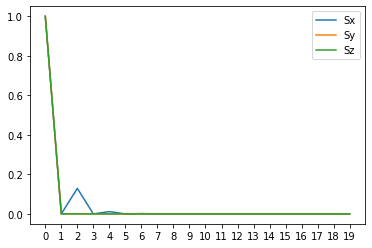

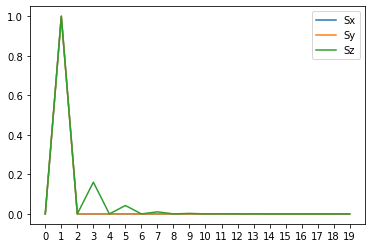

In [350]:
site_left = [0]
site_right = 20
xticks=range(site_right)
for op in ops:
    cf_list = 4*psi.correlation_function(op, op, site_left, site_right, opstr=op)[0, :]
    plt.plot(xticks, np.abs(cf_list), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.show()

site_left = [1]
site_right = 20
xticks=range(site_right)
for op in ops:
    cf_list = 4*psi.correlation_function(op, op, site_left, site_right, opstr=op)[0, :]
    plt.plot(xticks, np.abs(cf_list), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.show()

## Double Local Operators

Now let's try the 'double local operators'.

That is, we used two local, neighboring operators combined together as our |

In [351]:
def double_local_op(psi, op='Sx', i0=1, d=1):
    return psi.expectation_value_term(term=[(op, i0), (op, i0+1), (op, i0+d*2), (op, i0+d*2+1)])*16
def double_local_op_corr_func(psi, op='Sx', i0=1, dN=9):
    return [double_local_op(psi, op=op, i0=i0, d=d) for d in range(dN)]

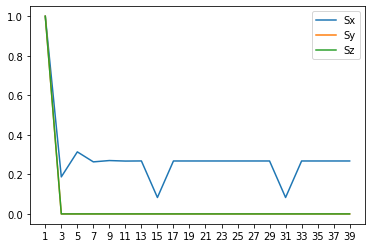

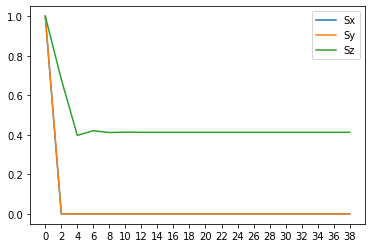

In [356]:
ops = ['Sx', 'Sy', 'Sz']
N=20

xticks=range(1, 2*N, 2)
for op in ops:
    plt.plot(xticks, double_local_op_corr_func(psi, op=op, i0=1, dN=N), label=op)
plt.legend()
plt.xticks(xticks)
plt.show()

xticks=range(0, 2*N, 2)
for op in ops:
    plt.plot(xticks, double_local_op_corr_func(psi, op=op, i0=0, dN=N), label=op)
plt.legend()
plt.xticks(xticks)
plt.show()


## Non-local operators

In [353]:
def nonlocal_op(psi, op='Sx', i0=1, end=11):
    if end==i0:
        return 1.0
    return psi.expectation_value_term(term=[(op, i) for i in range(i0, end)])*(2**(end-i0))
def nonlocal_op_corr_func(psi, op='Sx', i0=1, N=20):
    return [nonlocal_op(psi, op=op, i0=i0, end=i0+2*d) for d in range(N)]

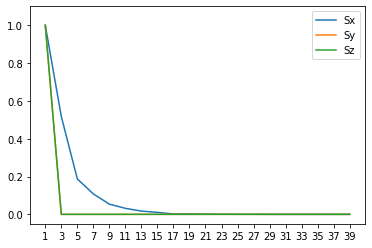

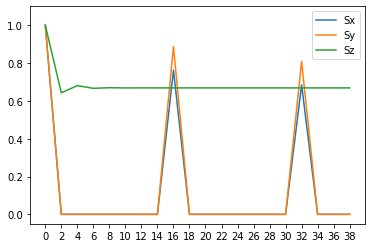

In [354]:
ops = ['Sx', 'Sy', 'Sz']
N=20

xticks=range(1, 2*N, 2)
for op in ops:
    plt.plot(xticks, np.abs(nonlocal_op_corr_func(psi, op=op, i0=1, N=N)), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.ylim(top=1.1)
plt.show()

xticks=range(0, 2*N, 2)
for op in ops:
    plt.plot(xticks, np.abs(nonlocal_op_corr_func(psi, op=op, i0=0, N=N)), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.ylim(top=1.1)
plt.show()


## Large Z

We choose a typical gapped point living in the large $Z$ limit, e.g.
$$ J_x^2 + J_y^2 = 0.1$$

In [373]:
# set the region to be the circle `r = x**2 + y**2 = 2, z=.5`
r = 0.1
theta = .1
Jx = r * np.cos(theta)
Jy = r * np.sin(theta)
Jz = 1

result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=8, chi=128, bc='periodic', bc_MPS='infinite')

Reading 'L'=8 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=0.09950041652780259 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.009983341664682815 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSite

In [374]:
psi = result['psi']

## Validation of the Ground State

### Test with our theoretical energy

In [376]:
np.abs(result['energy'] - E_true(Jx, Jy, Jz))

1.4487843093269337e-06

### Test with our local symmetries

In [377]:
k=0
print("Norm: <psi|psi> = %.1f" % psi.norm)
for k in range(20):
    if k % 2 == 0:
        print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sx', k), ('Sy', k+1), ('Sy', k+2), ('Sx', k+3)])))
#         print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sy', k), ('Sx', k+1), ('Sx', k+2), ('Sy', k+3)])))
#     

Norm: <psi|psi> = 1.0
Local Symmetry: W0 = 1.0
Local Symmetry: W1 = 1.0
Local Symmetry: W2 = 1.0
Local Symmetry: W3 = 1.0
Local Symmetry: W4 = 1.0
Local Symmetry: W5 = 1.0
Local Symmetry: W6 = 1.0
Local Symmetry: W7 = 1.0
Local Symmetry: W8 = 1.0
Local Symmetry: W9 = 1.0


## Local Operators

In [378]:
ops = ['Sx', 'Sy', 'Sz']

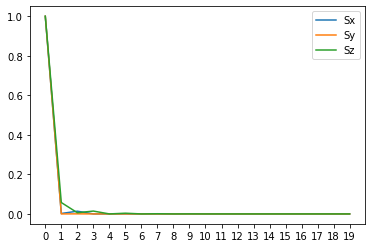

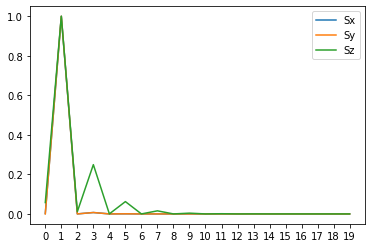

In [379]:
site_left = [0]
site_right = 20
xticks=range(site_right)
for op in ops:
    cf_list = 4*psi.correlation_function(op, op, site_left, site_right, opstr=op)[0, :]
    plt.plot(xticks, np.abs(cf_list), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.show()

site_left = [1]
site_right = 20
xticks=range(site_right)
for op in ops:
    cf_list = 4*psi.correlation_function(op, op, site_left, site_right, opstr=op)[0, :]
    plt.plot(xticks, np.abs(cf_list), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.show()

## Double Local Operators

Now let's try the 'double local operators'.

That is, we used two local, neighboring operators combined together as our |

In [380]:
def double_local_op(psi, op='Sx', i0=1, d=1):
    return psi.expectation_value_term(term=[(op, i0), (op, i0+1), (op, i0+d*2), (op, i0+d*2+1)])*16
def double_local_op_corr_func(psi, op='Sx', i0=1, dN=9):
    return [double_local_op(psi, op=op, i0=i0, d=d) for d in range(dN)]

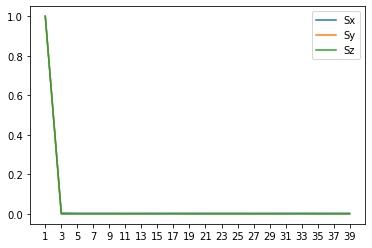

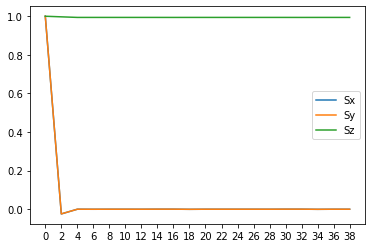

In [381]:
ops = ['Sx', 'Sy', 'Sz']
N=20

xticks=range(1, 2*N, 2)
for op in ops:
    plt.plot(xticks, double_local_op_corr_func(psi, op=op, i0=1, dN=N), label=op)
plt.legend()
plt.xticks(xticks)
plt.show()

xticks=range(0, 2*N, 2)
for op in ops:
    plt.plot(xticks, double_local_op_corr_func(psi, op=op, i0=0, dN=N), label=op)
plt.legend()
plt.xticks(xticks)
plt.show()


## Non-local operators

In [382]:
def nonlocal_op(psi, op='Sx', i0=1, end=11):
    if end==i0:
        return 1.0
    return psi.expectation_value_term(term=[(op, i) for i in range(i0, end)])*(2**(end-i0))
def nonlocal_op_corr_func(psi, op='Sx', i0=1, N=20):
    return [nonlocal_op(psi, op=op, i0=i0, end=i0+2*d) for d in range(N)]

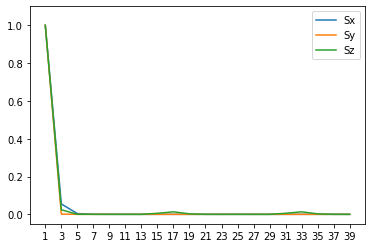

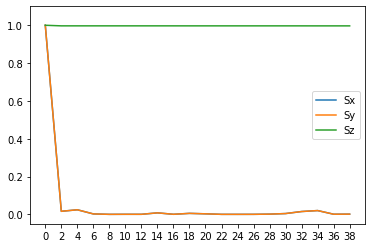

In [383]:
ops = ['Sx', 'Sy', 'Sz']
N=20

xticks=range(1, 2*N, 2)
for op in ops:
    plt.plot(xticks, np.abs(nonlocal_op_corr_func(psi, op=op, i0=1, N=N)), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.ylim(top=1.1)
plt.show()

xticks=range(0, 2*N, 2)
for op in ops:
    plt.plot(xticks, np.abs(nonlocal_op_corr_func(psi, op=op, i0=0, N=N)), '-', label=op)
plt.legend()
plt.xticks(xticks)
plt.ylim(top=1.1)
plt.show()


In [415]:
# set the region to be the circle `r = x**2 + y**2 = 2, z=.5`

r = 2
theta = np.pi * 9 / 90
Jx = -r*np.cos(theta)
Jy = r*np.sin(theta)
Jz = .5

result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=8, chi=128, bc='periodic', bc_MPS='infinite')

Reading 'L'=8 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=-1.902113032590307 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.6180339887498948 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteD

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [38, 49, 38, 48, 38, 48, 38, 48, 38, 48, 38, 48, 38, 48, 38, 48]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000147-1.3576921704955207e-16j)
After the canonicalization:
Bond dim =  [38, 49, 38, 48, 38, 48, 38, 48, 38, 48, 38, 48, 38, 48, 38, 48]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================


## Validation of the Ground State

### Test with our theoretical energy

In [416]:
psi = result['psi']
np.abs(result['energy'] - E_true(Jx, Jy, Jz))

7.130407375655068e-14

In [417]:
print(E_true(Jx, Jy, Jz))
print(E_false(Jx, Jy, Jz))

-0.24904005789277786
-0.2476191661911536


### Test with our local symmetries

In [418]:
psi = result['psi']
print("Norm: <psi|psi> = %.1f" % psi.norm)
for k in range(20):
    if k % 2 == 0:
        print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sx', k), ('Sy', k+1), ('Sy', k+2), ('Sx', k+3)])))
#         print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sx', k), ('Sz', k+1), ('Sz', k+2), ('Sx', k+3)])))
#         print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sz', k), ('Sy', k+1), ('Sy', k+2), ('Sz', k+3)])))
#         print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sy', k), ('Sx', k+1), ('Sx', k+2), ('Sy', k+3)])))

Norm: <psi|psi> = 1.0
Local Symmetry: W0 = -1.0
Local Symmetry: W1 = -1.0
Local Symmetry: W2 = -1.0
Local Symmetry: W3 = -1.0
Local Symmetry: W4 = -1.0
Local Symmetry: W5 = -1.0
Local Symmetry: W6 = -1.0
Local Symmetry: W7 = -1.0
Local Symmetry: W8 = -1.0
Local Symmetry: W9 = -1.0


In [407]:
# set the region to be the circle `r = x**2 + y**2 = 2, z=.5`

r = 2
theta = np.pi * 9 / 90
Jx = -r*np.cos(theta)
Jy = r*np.sin(theta)
Jz = .5

result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=8, chi=128, bc='periodic', bc_MPS='finite')

Reading 'L'=8 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=-1.902113032590307 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.6180339887498948 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [412]:
psi = result['psi']
print("Norm: <psi|psi> = %.1f" % psi.norm)
for k in range(14):
    if k % 2 == 0:
        print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sx', k), ('Sy', k+1), ('Sy', k+2), ('Sx', k+3)])))
#         print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sx', k), ('Sz', k+1), ('Sz', k+2), ('Sx', k+3)])))
#         print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sz', k), ('Sy', k+1), ('Sy', k+2), ('Sz', k+3)])))
#         print(r"Local Symmetry: W%d = %.1f" % (k//2, 16*psi.expectation_value_term(term=[('Sy', k), ('Sx', k+1), ('Sx', k+2), ('Sy', k+3)])))

Norm: <psi|psi> = 1.0
Local Symmetry: W0 = -1.0
Local Symmetry: W1 = -1.0
Local Symmetry: W2 = -1.0
Local Symmetry: W3 = -1.0
Local Symmetry: W4 = -1.0
Local Symmetry: W5 = -1.0
Local Symmetry: W6 = -1.0


## Perturbation

What kinds of perturbation:
1. pure `Jz`: spin pairs (dimers) up or down 
    consider the interactions between the pairs.
    
Corr. len.
    